In [1]:
import cv2
import scipy
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Image Data Preprocessing for Puck (rondelle) Detection

This code snippet is dedicated to the preprocessing of image data for puck detection. It specifically handles images containing a puck (`images_with_puck`) and images without a puck (`images_without_puck`). The goal is to prepare the data for subsequent use in training a machine learning model for puck detection. This section reads and processes images with a puck. It uses OpenCV to read and resize images to a standard size of (224, 224). The images are also converted from BGR to RGB format. The processed images are stored in the with_puck_img list, and corresponding labels are stored in the label_with_puck_img list with a label of 1 indicating the presence of a puck.


In [2]:
with_puck_img=[]
label_with_puck_img=[]
for img in glob.glob("..\Training_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

without_puck_img=[]
label_without_puck_img=[]
for img in glob.glob("..\Training_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

This section converts the processed image data and labels into NumPy arrays for further use. It also provides information about the total number of images with and without a puck.

In [3]:
with_puck_img  = np.array(with_puck_img) 
label_with_puck_img  = np.array(label_with_puck_img) 
without_puck_img  = np.array(without_puck_img) 
label_without_puck_img  = np.array(label_without_puck_img) 

print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

Total number of puck images: 35
Total number of without puck images: 37


## Data Concatenation and Normalization

This code snippet is responsible for concatenating the processed image data and labels for further use in machine learning. It combines images with a puck (`with_puck_img`) and images without a puck (`without_puck_img`), normalizes the pixel values, and creates corresponding labels (`y`).


In [4]:
X = np.concatenate((with_puck_img,without_puck_img ), axis=0)/255.0
y = np.concatenate((label_with_puck_img,label_without_puck_img ), axis=0)

## Train-test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape

(48, 224, 224, 3)

# Evaluation of the Model on Test set

To assess the trained model's performance, a fresh test dataset is formed using frames from the 'val.avi'. The model's evaluation involves the use of a confusion matrix and ROC curve.

In [6]:
# Lists to store images and labels with puck
with_puck_img = []
label_with_puck_img = []

# Load images with puck and preprocess
for img in glob.glob("..\Test_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

# Lists to store images and labels without puck
without_puck_img = []
label_without_puck_img = []

# Load images without puck and preprocess
for img in glob.glob("..\Test_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

# Convert lists to NumPy arrays
with_puck_img = np.array(with_puck_img)
label_with_puck_img = np.array(label_with_puck_img)
without_puck_img = np.array(without_puck_img)
label_without_puck_img = np.array(label_without_puck_img)

# Display total number of images for each class
print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

# Create the test dataset
X_test = np.concatenate((with_puck_img, without_puck_img[::5]), axis=0) / 255.0
y_test = np.concatenate((label_with_puck_img, label_without_puck_img[::5]), axis=0)




Total number of puck images: 76
Total number of without puck images: 876


# Evaluating various structure of the CNN 

In [7]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
)


def CreateCNN_Model(num_layers_cnn):
    # Assert that num_layers_cnn is an integer and within the specified range
    assert isinstance(num_layers_cnn, int), "num_layers_cnn should be an integer"
    assert num_layers_cnn in [1, 2, 3], "num_layers_cnn should be 1, 2, or 3"

    # Create a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    if num_layers_cnn >= 2:
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    if num_layers_cnn >= 3:
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## AUC metric
The Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve is used for model evaluation.

In [ ]:
AUC_metric = []

for num in [1,2,3]:

    print(f"Training for Number of layer: {num}")

    cnn_exp_model = CreateCNN_Model(num_layers_cnn=num)

    # Train the model
    history = cnn_exp_model.fit(
        X_train, y_train,
        epochs=100,  # You can adjust the number of epochs
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred = cnn_exp_model.predict(X_test)

    # Evaluate the model using ROC curve and calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    AUC_metric.append(auc*100)
    print(f"The AUC for {num}-layered CNN is: {auc*100}")



    

Training for Number of layer: 1
The AUC for 1-layered CNN is: 22.73474880382775
Training for Number of layer: 2
The AUC for 2-layered CNN is: 21.022727272727273
Training for Number of layer: 3
The AUC for 3-layered CNN is: 99.99252392344498


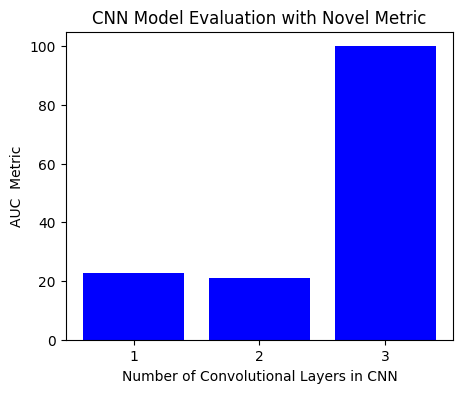

In [23]:
# Plotting the bar chart
plt.figure(figsize=(5,4))
plt.bar([1, 2, 3], AUC_metric, color='blue')
plt.xlabel('Number of Convolutional Layers in CNN')
plt.ylabel('AUC  Metric')
plt.title('CNN Model Evaluation with Novel Metric')
plt.xticks([1, 2, 3])
plt.show()

# Visualizing the embeddibgs using T-SNE

In [9]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

cnn_exp_model = CreateCNN_Model(num_layers_cnn=3)

for idx in [1,2,3,4,5,6,7,8,9,10]:
    

    # Train the model
    history = cnn_exp_model.fit(
        X_train, y_train,
        epochs=10,  # You can adjust the number of epochs
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    print(f'After {idx*10} epoches')

    val_loss = history.history['val_loss'][-1]
    val_acc =  history.history['val_accuracy'][-1]

    feature_extractor = Model(cnn_exp_model.inputs,cnn_exp_model.get_layer(index=-3).output)

    # from sklearn.manifold import TSNE

    X_embed = feature_extractor(X_train).numpy()

    pca = PCA(n_components=2)#TSNE(n_components=2,perplexity=8, random_state=42)
    X_tsne = pca.fit_transform(X_embed)

    # Plot the t-SNE scatter plot
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, s=70)
    plt.title(f'Val_accuracy: {val_acc:.3f} and Val Loss: {val_loss:.3f}')
    plt.savefig(f'..\Result_images\{idx*10}.png',dpi=100)
    plt.show()


ResourceExhaustedError:  OOM when allocating tensor with shape[16,32,111,111] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/max_pooling2d_3/MaxPool
 (defined at c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\layers\pooling.py:357)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1996]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/max_pooling2d_3/MaxPool:
In[0] sequential_1/conv2d_3/Relu (defined at c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\backend.py:4867)

Operation defined at: (most recent call last)
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 601, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1905, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_15700\4151081265.py", line 10, in <module>
>>>     history = cnn_exp_model.fit(
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\layers\pooling.py", line 357, in call
>>>     outputs = self.pool_function(
>>> 